In [1]:
import numpy as np
import random
import copy
import cv2 as cv
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import time

## Generate a coastline

Mapping

0 - Terrain (solid ground, terrain)

1 - Sand (loose sand)

2 - Water

3 - Solid Objects ? 

In [2]:
def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])
    
def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*d)**2)/lengthScale**2)


def get_coast_noise(scaling_factor=3, period=1, noise_level=0.01):
    x = np.linspace(0,DIM_MAP, DIM_MAP).reshape(-1,1)
    K = periodic_kernel(x,x,1,period,1) + white_kernel(x,None,noise_level)
    mu = np.zeros(x.shape)
    
    f = scaling_factor* np.random.multivariate_normal(mu.flatten(), K, 1)[0]
    return f

In [78]:
GROUND_COLOR = [29,118,56]
SAND_COLOR = [153,229, 255]
WATER_COLOR = [204,134,41]
FRAC_GROUND, FRAC_SAND = 0.3, 0.3
DIM_MAP = 1000
COAST_VAR = 0.15
WAVE_FREQ = 20
WAVE_SPEED = 1


GROUND_COLOR.reverse()
SAND_COLOR.reverse()
WATER_COLOR.reverse()

In [79]:
def display_map(coast, waves_inp=[], waves_pos=[], stream=True, openCV=False):
    global GROUND_COLOR, SAND_COLOR, WATER_COLOR
    
    cv.namedWindow("Coast")
    
    img = np.zeros((coast.shape[0], coast.shape[1],3), dtype=int)
    
    
    img[np.where(coast==0)] = GROUND_COLOR   ## Ground Color
    img[np.where(coast==1)] = SAND_COLOR   ## Sand Color
    img[np.where(coast==2)] = WATER_COLOR   ## Water Color

    if len(waves_inp) > 0:
        for i in range(DIM_MAP):
            img[i,waves_inp[:,i]] = [0,0,255]

    if not openCV:
        plt.imshow(img)
        plt.show()



    if openCV:
        img = img.astype(np.uint8)
        img_cv = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        img_cv = cv.resize(img_cv, (1000,1000))
        
        cv.imshow("Coast", img_cv)
        if stream:
            cv.waitKey(2)
        else:
            cv.waitKey(0)
            cv.destroyWindow("Coast")
            cv.waitKey(1)

In [80]:
coast_map = np.zeros((DIM_MAP, DIM_MAP), dtype=np.int16)

In [81]:
coast_map[:,int(DIM_MAP*FRAC_GROUND):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))] = 1  ## Assign sand portion of the map
coast_map[:,int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):] = 2  ## Assign water portion of the map


lower_limit = - (COAST_VAR * DIM_MAP) / 2 
upper_limit =  (COAST_VAR * DIM_MAP) / 2


-ve -> Push water towards sand


+ve -> Push sand towards water

In [110]:
rand_coast = get_coast_noise(scaling_factor=DIM_MAP / 20, period=0.5, noise_level=1 / DIM_MAP)
rand_terrain = get_coast_noise(scaling_factor=DIM_MAP/20, period=0.5, noise_level=1 / DIM_MAP)
# plt.plot(rand_coast)

In [111]:
temp_coast = copy.deepcopy(coast_map)

for i in range(len(rand_coast)):
    if rand_coast[i] < 0:
        temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))+int(rand_coast[i]):] = 2
    else:
        temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):int(rand_coast[i])+int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))] = 1

    if rand_terrain[i] < 0:
        temp_coast[i, int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))] = 1
    else:
        temp_coast[i, :int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i])] = 0


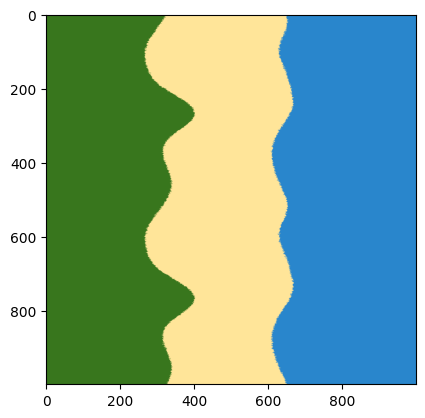

In [112]:
display_map(temp_coast)

In [125]:
def calculate_wave_pos(waves, pos):
    return np.clip(np.add(waves,pos),0,DIM_MAP-1).astype(np.int16)

def run_sim():
    global WAVE_FREQ, WAVE_SPEED

    
    waves = np.array([get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16)])
    pos = np.array([np.ones(waves[0].shape) * DIM_MAP])
    for t in range(1,10000):
        if t%WAVE_FREQ == 0:
            new_wave = get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16).reshape(1,-1)
            waves = np.append(waves, new_wave, axis=0)
            pos = np.append(pos,np.ones(new_wave.shape) * DIM_MAP, axis=0)
            display_map(temp_coast, calculate_wave_pos(waves, pos))
        pos = pos - WAVE_SPEED
        display_map(temp_coast, calculate_wave_pos(waves, pos), openCV=True)
        # time.sleep(0.5)

In [126]:
WAVE_FREQ = 100

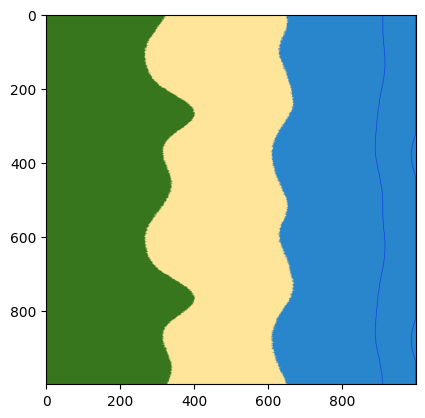

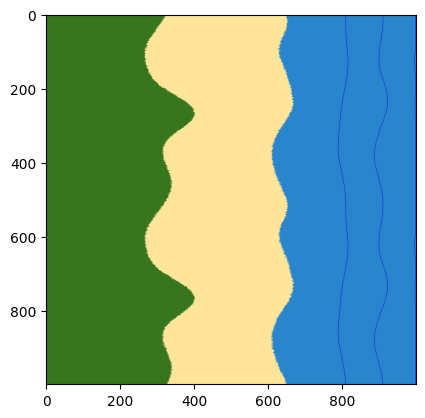

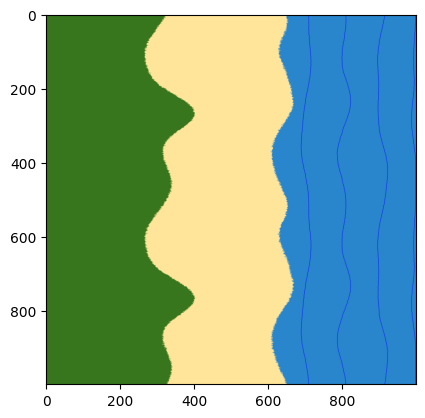

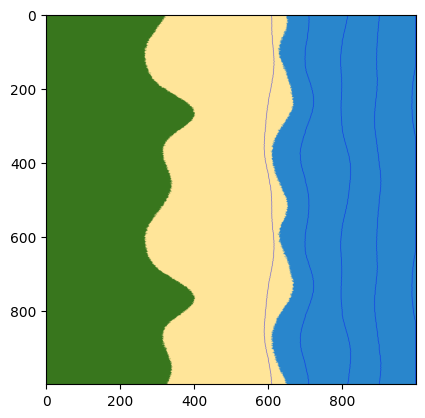

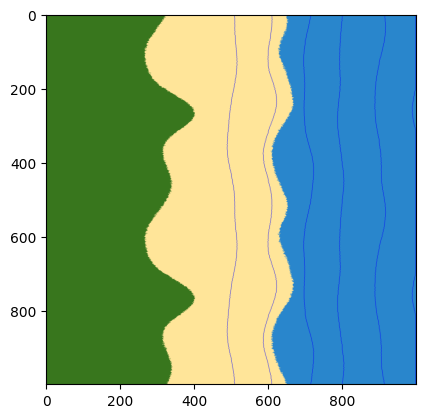

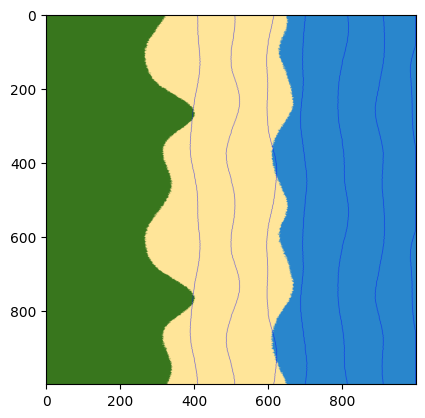

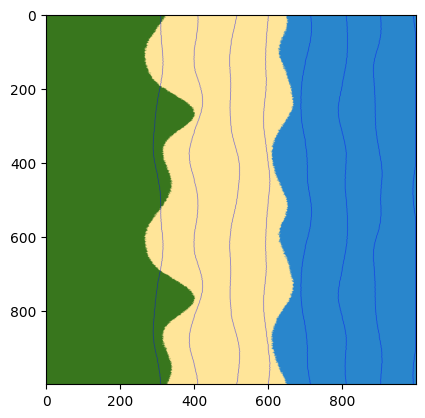

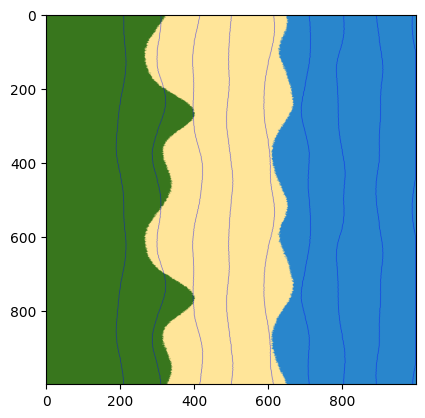

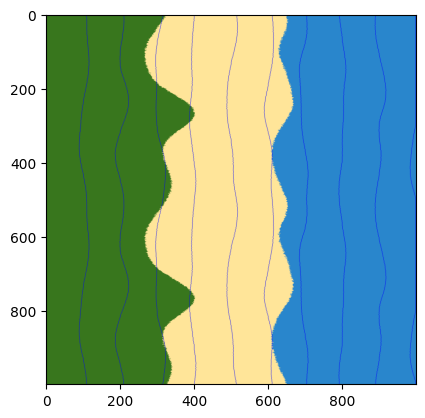

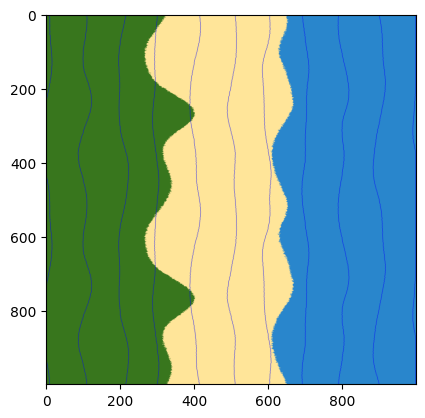

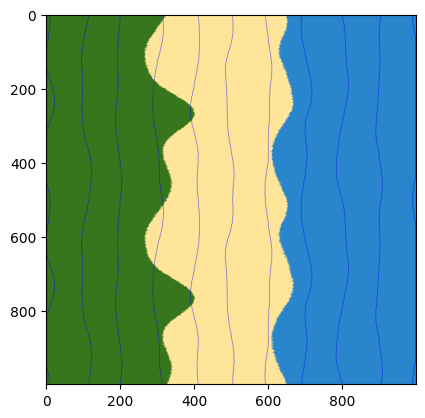

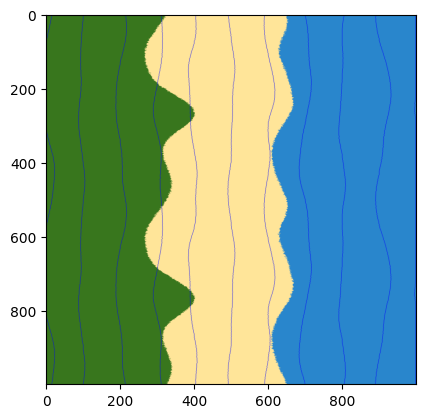

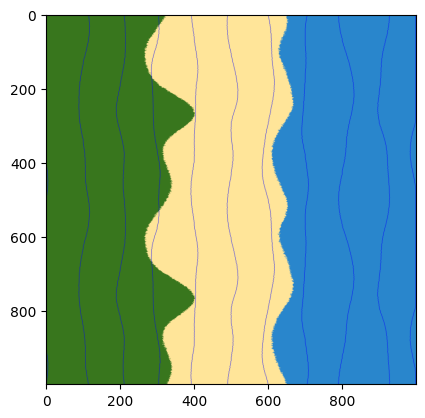

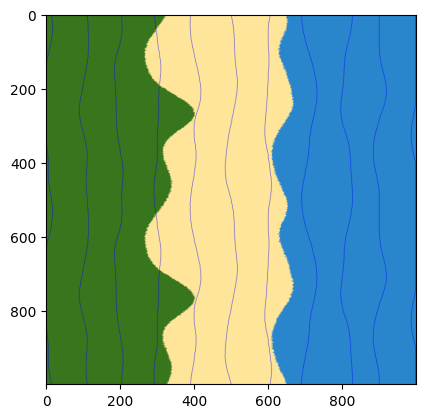

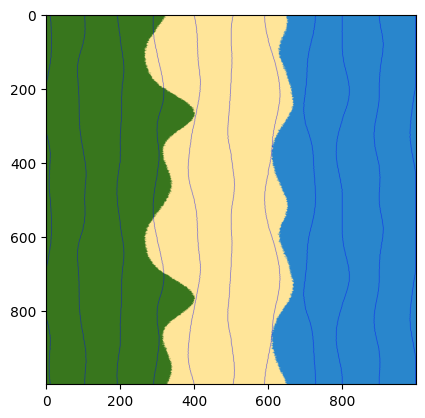

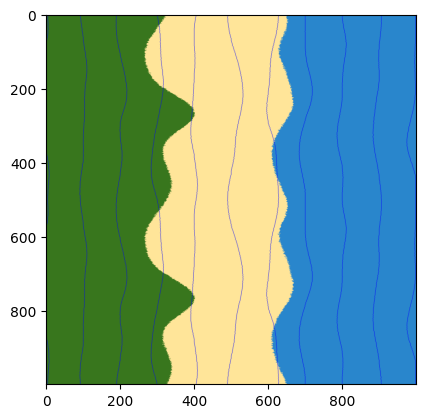

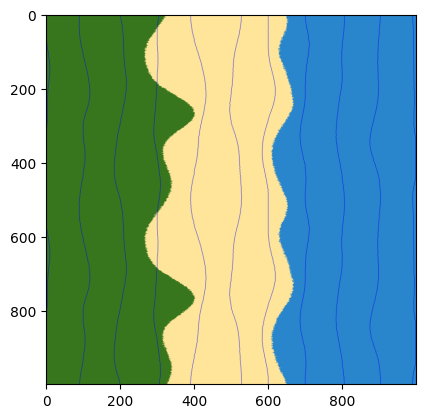

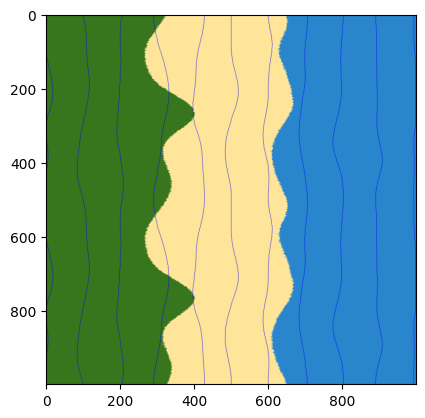

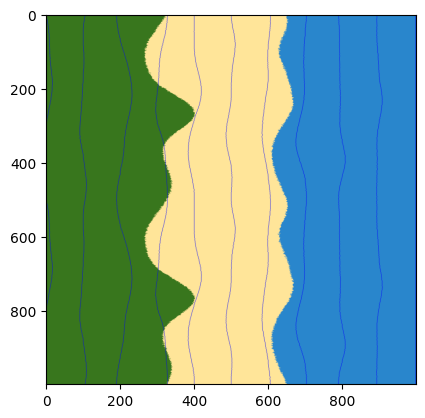

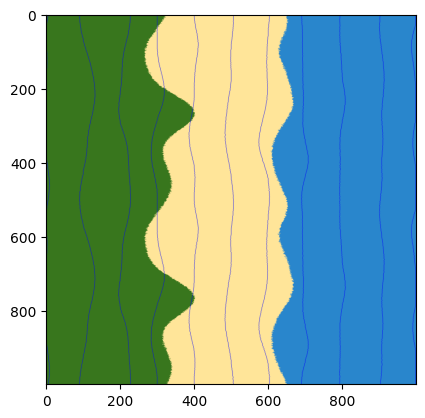

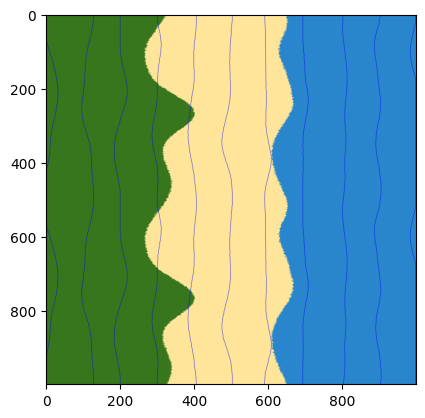

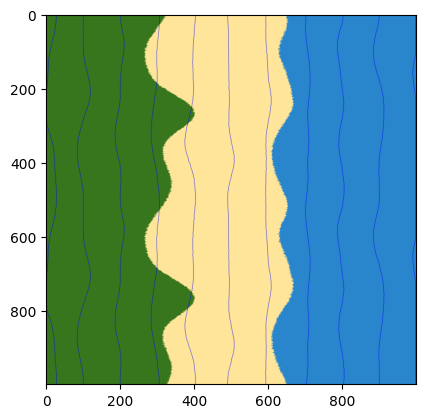

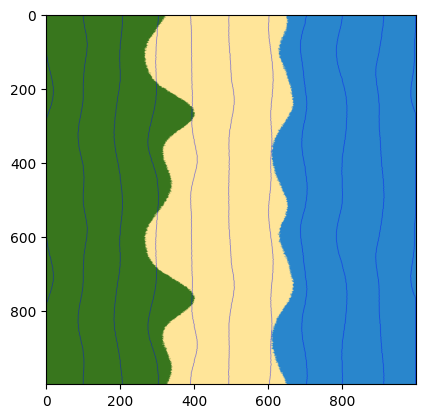

KeyboardInterrupt: 

In [127]:
run_sim()

## TO DO
Waves - strength (wind, amount of water), weaken_waves, terminate waves, retreat waves


Solid objects

Movement of sand/retreat water

Terrain height/3rd dimension

Movement of Terrain - Very strong terrain/ low coefficient of movement

Use EmuKit for simulation ? 

Bayesian optimization to get the parameters accurate to simulate the japan shoreline - After full simulator is built